In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import seaborn as sns
import os
from scipy import signal, optimize

In [2]:
def load_dataset():
    df_list = []
    
    for directory in ['matrix-mul', 'cublas', 'cuda-tensor']:
        files = os.listdir(directory)
        # Get efimon files
        for i in files:
            if 'efimon' in i:
                df = pd.read_csv(os.path.join(directory, i)).iloc[2:30]
                name = i.split('-')[1].split('.')[0]
                df["sleep_us"] = int(name)
                df["benchmark"] = directory
                df_list.append(df)
    # Concat everything
    df = pd.concat([i for i in df_list if i is not None])
    return df, df_list

In [3]:
def load_histograms():
    df = pd.DataFrame()
    files = ['ptx/cublas.csv', 'ptx/cuda-tensor.csv', 'ptx/matrix-mul.csv']
    for i in files:
        dft = pd.read_csv(i).transpose()
        name = i.split('/')[1].split('.')[0]
        df[name] = dft
    # Concat everything
    return df

In [4]:
df, df_list = load_dataset()
dfh = load_histograms()

# Raw Data

In [5]:
df.head()

,OverallUsage(perc),OverallMemory(perc),OverallPower(W),ClockSM(MHz),ClockMEM(MHz),sleep_us,benchmark
2,64,23,122.3670,1380,877,20000,matrix-mul
3,64,23,122.3460,1380,877,20000,matrix-mul
4,64,23,122.4710,1380,877,20000,matrix-mul
5,64,23,96.8406,1380,877,20000,matrix-mul
6,64,23,122.6920,1380,877,20000,matrix-mul


In [6]:
dfh

,cublas,cuda-tensor,matrix-mul
vector_arithmetic,0.000000,0.403460,0.000000
vector_memory,0.114754,0.520088,0.000000
branching,0.081967,0.027187,0.044872
scalar_arithmetic,0.444262,0.035264,0.358975
scalar_logic,0.145902,0.008865,0.051282
scalar_memory,0.213100,0.005122,0.544873


<Axes: xlabel='OverallUsage(perc)', ylabel='OverallPower(W)'>

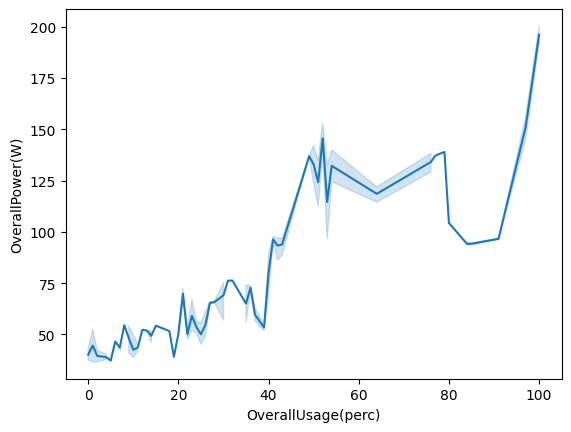

In [7]:
sns.lineplot(df, x='OverallUsage(perc)', y='OverallPower(W)')

<Axes: xlabel='OverallUsage(perc)', ylabel='ClockSM(MHz)'>

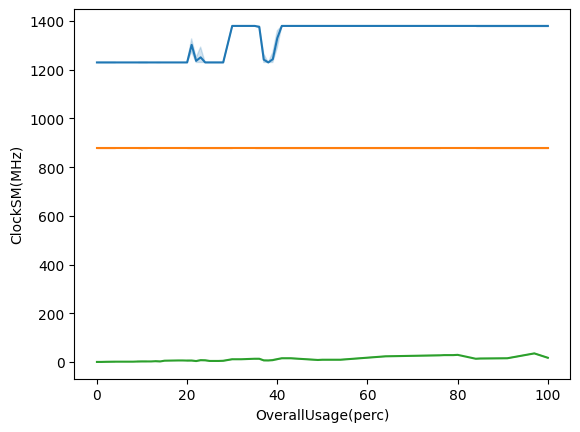

In [153]:
sns.lineplot(df, x='OverallUsage(perc)', y='ClockSM(MHz)' )
sns.lineplot(df, x='OverallUsage(perc)', y='ClockMEM(MHz)' )
sns.lineplot(df, x='OverallUsage(perc)', y='OverallMemory(perc)' )

<Axes: xlabel='ClockMEM(MHz)', ylabel='OverallPower(W)'>

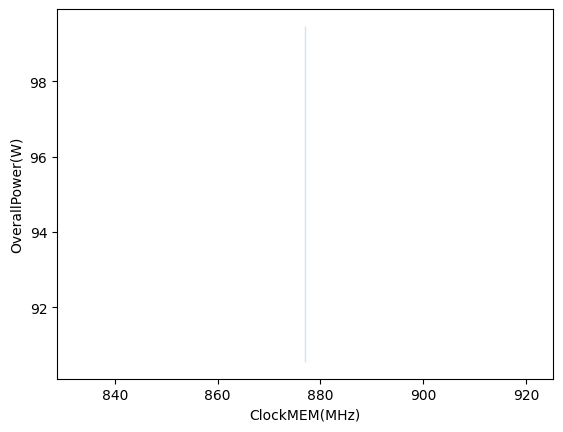

In [9]:
sns.lineplot(df, x='ClockMEM(MHz)', y='OverallPower(W)')

# Filtered

<Axes: xlabel='OverallUsage(perc)', ylabel='MedianOverallPower(W)'>

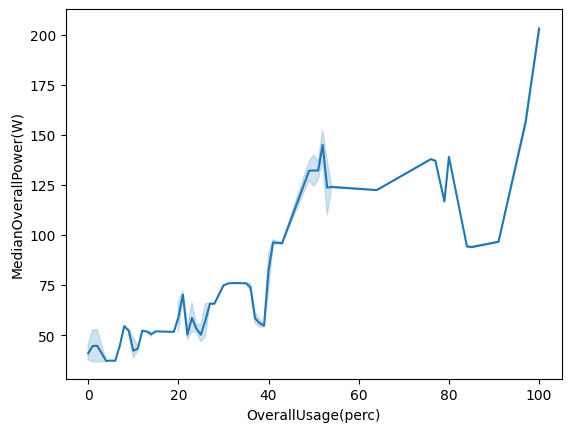

In [10]:
df["MedianOverallPower(W)"] = signal.medfilt(df['OverallPower(W)'], 3)
sns.lineplot(df, x='OverallUsage(perc)', y='MedianOverallPower(W)')

Not effective!

# Try LS

In [11]:
df["unit"] = 1.
independent_variables = ['OverallUsage(perc)', "unit"]
A = df[independent_variables].to_numpy()
b = df['OverallPower(W)'].to_numpy()

In [12]:
coeff_1, _ = optimize.nnls(A, b, maxiter=1000)

In [13]:
#sol = optimize.lsq_linear(A, b, max_iter=1000)
#coeff_1 = sol["x"]

In [14]:
coeff_1

array([ 1.34023943, 30.5624184 ])

In [15]:
intercept_1 = coeff_1[-1]

In [16]:
prediction = []
for row in A:
    prediction.append(row.dot(coeff_1))
df["prediction"] = prediction

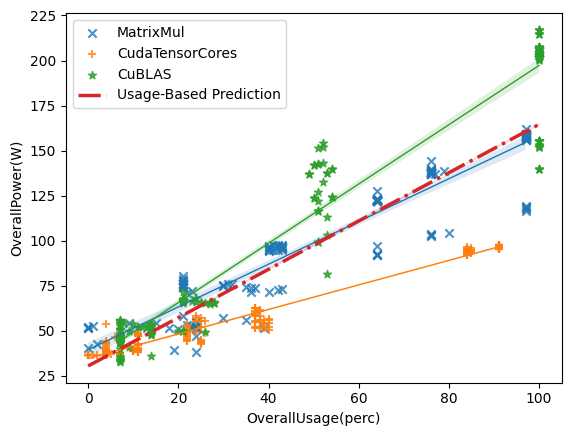

In [17]:
#sns.lineplot(df, x='OverallUsage(perc)', y='OverallPower(W)', label='Overall')
sns.regplot(df[df['benchmark'] == 'matrix-mul'], x='OverallUsage(perc)', y='OverallPower(W)', label='MatrixMul',marker="x", line_kws=dict(linewidth=1))
sns.regplot(df[df['benchmark'] == 'cuda-tensor'], x='OverallUsage(perc)', y='OverallPower(W)', label='CudaTensorCores',marker="+", line_kws=dict(linewidth=1))
sns.regplot(df[df['benchmark'] == 'cublas'], x='OverallUsage(perc)', y='OverallPower(W)', label='CuBLAS', marker="*", line_kws=dict(linewidth=1))
sns.lineplot(df, x='OverallUsage(perc)', y='prediction', label='Usage-Based Prediction', linewidth=2.5, linestyle='-.')
plt.legend()

# Analyse Histograms

In [18]:
dfh.index

Index(['vector_arithmetic', 'vector_memory', 'branching', 'scalar_arithmetic',
       'scalar_logic', 'scalar_memory'],
      dtype='object')

In [19]:
names = ['matrix-mul', 'cublas', 'cuda-tensor']

(0.0, 0.6)

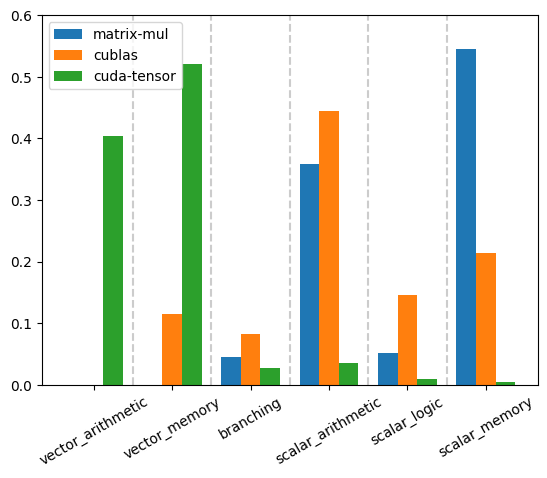

In [20]:
X = np.arange(len(dfh.index))
width = 0.25
multiplier = 0
for name in names:
    offset = width * multiplier
    plt.bar(X + offset, dfh[name], width, label=name)
    multiplier += 1
plt.legend()
_ = plt.xticks(X + width, dfh.index, rotation=30)
plt.vlines(X[:-1] + 0.75, ymin=0, ymax=0.6, color="#CCC", ls="--")
plt.ylim(0, 0.6)

# Integrate Histograms

In [21]:
dfht = dfh.transpose()
dfht["experiment"] = dfht.index
metrics = dfht.columns.values

In [22]:
df

,OverallUsage(perc),OverallMemory(perc),OverallPower(W),ClockSM(MHz),ClockMEM(MHz),sleep_us,benchmark,MedianOverallPower(W),unit,prediction
2,64,23,122.3670,1380,877,20000,matrix-mul,122.346,1.0,116.337742
3,64,23,122.3460,1380,877,20000,matrix-mul,122.367,1.0,116.337742
4,64,23,122.4710,1380,877,20000,matrix-mul,122.346,1.0,116.337742
5,64,23,96.8406,1380,877,20000,matrix-mul,122.471,1.0,116.337742
6,64,23,122.6920,1380,877,20000,matrix-mul,122.379,1.0,116.337742
...,...,...,...,...,...,...,...,...,...,...
25,91,15,97.9260,1380,877,500,cuda-tensor,97.814,1.0,152.524207
26,91,15,97.7320,1380,877,500,cuda-tensor,97.732,1.0,152.524207
27,91,15,97.5390,1380,877,500,cuda-tensor,97.732,1.0,152.524207
28,91,15,97.7320,1380,877,500,cuda-tensor,97.732,1.0,152.524207


In [34]:
def integrate_instructions(df):
    df[metrics] = 0.0
    for i in names:
        for metric in metrics:
            #df[df["benchmark"] == i][metric] = dfht[dfht["experiment"] == i][metric]
            val = dfht[dfht["experiment"] == i][metric]
            df.loc[lambda df: df["benchmark"] == i, metric] = val.values[0]
    return df

In [35]:
df = integrate_instructions(df)

/tmp/ipykernel_113447/2117647109.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'matrix-mul' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[lambda df: df["benchmark"] == i, metric] = val.values[0]


# Perform the Linear Regression

In [25]:
df["unit"] = 1.
independent_variables2 = ['OverallUsage(perc)', "unit"] + list(metrics[:-1])
A2 = df[independent_variables2].to_numpy()
b2 = df['OverallPower(W)'].to_numpy()

In [48]:
rr = optimize.lsq_linear(A2, b2, max_iter=1000, lsq_solver='lsmr')

In [63]:
rr

       message: The unconstrained solution is optimal.
       success: True
        status: 3
           fun: [-6.488e+00 -6.467e+00 ...  2.902e+01  2.902e+01]
             x: [ 1.226e+00  3.113e+01 -3.327e+01 -9.986e+00  1.349e+01
                  6.232e+01  3.222e+01 -3.366e+01]
           nit: 0
          cost: 105185.96511739562
    optimality: 2.1312160924935597e-09
   active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                  0.000e+00  0.000e+00  0.000e+00]
 unbounded_sol: (array([ 1.226e+00,  3.113e+01, -3.327e+01, -9.986e+00,
                        1.349e+01,  6.232e+01,  3.222e+01, -3.366e+01]), 2, 5, 458.66319912850145, np.float64(2.938602231383507e-11), 2023.5220054430633, np.float64(156.42293007554042), np.float64(91.72878544794911))

In [28]:
coeff_2 = rr["x"]

In [29]:
prediction2 = []
for row in A2:
    prediction2.append(row.dot(coeff_2))
df["prediction-full"] = prediction

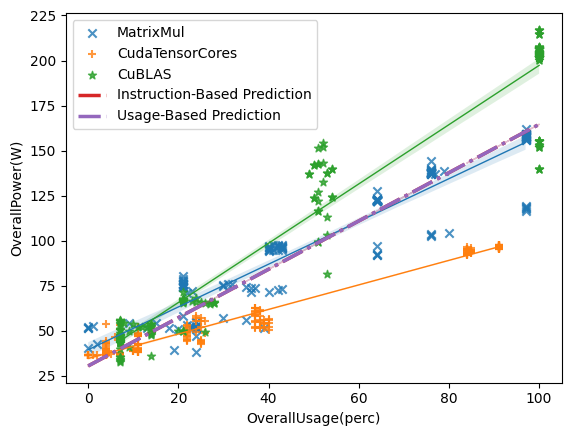

In [30]:
#sns.lineplot(df, x='OverallUsage(perc)', y='OverallPower(W)', label='Overall')
sns.regplot(df[df['benchmark'] == 'matrix-mul'], x='OverallUsage(perc)', y='OverallPower(W)', label='MatrixMul',marker="x", line_kws=dict(linewidth=1))
sns.regplot(df[df['benchmark'] == 'cuda-tensor'], x='OverallUsage(perc)', y='OverallPower(W)', label='CudaTensorCores',marker="+", line_kws=dict(linewidth=1))
sns.regplot(df[df['benchmark'] == 'cublas'], x='OverallUsage(perc)', y='OverallPower(W)', label='CuBLAS', marker="*", line_kws=dict(linewidth=1))
sns.lineplot(df, x='OverallUsage(perc)', y='prediction-full', label='Instruction-Based Prediction', linewidth=2.5, linestyle='-.')
sns.lineplot(df, x='OverallUsage(perc)', y='prediction', label='Usage-Based Prediction', linewidth=2.5, linestyle='-.')
plt.legend()

# Error Plot


In [41]:
def assign_colors(labels):
    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)
    color_map = plt.get_cmap('tab20')  # You can change the color map here

    label_to_color = {}
    for i, label in enumerate(unique_labels):
        label_to_color[label] = color_map(i / num_labels)

    return label_to_color
    
name_to_color = assign_colors(df["benchmark"])

(25.0, 225.0)

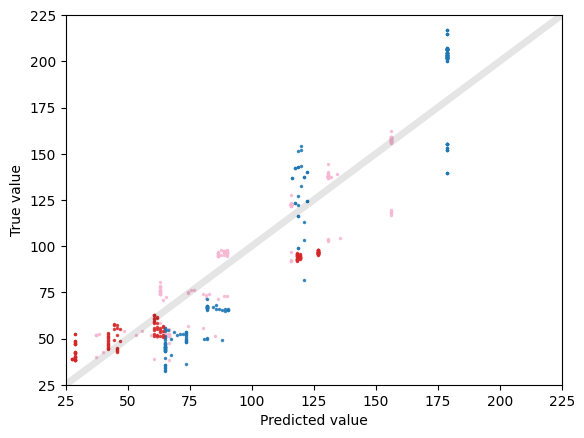

In [45]:
import warnings
warnings.filterwarnings('ignore')

for dfi in df_list:
    name = dfi["benchmark"].unique()[0]
    df1 = integrate_instructions(dfi.copy())
    df1["unit"] = 1.
    prediction = []
    for row in df1[independent_variables2].to_numpy():
        prediction.append(row@coeff_2)
        
    df1["prediction"]=prediction
    plt.plot(df1["prediction"], df1["OverallPower(W)"], '.', markersize=3,  alpha=0.8, fillstyle='full', markeredgewidth=1, label=name, color=name_to_color[name])

plt.plot([0,250],[0,250], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())
plt.ylabel("True value")
plt.xlabel("Predicted value")
plt.xlim([25,225])
plt.ylim([25,225])


# Perform Some Normalisation

In [304]:
def Normalise(df):
    probs_vars = ['vector_arithmetic', 'vector_memory', 'branching', 'scalar_arithmetic', 'scalar_logic', 'scalar_memory']
    independent_vars = ['unit'] + ["norm_" + i for i in probs_vars] + ['bw_memory_scalar', 'bw_memory_vector']
    df["unit"] = 1.0

    for var in probs_vars:
        # Linear
        #df["norm_" + var] = df[var] *  df["OverallUsage(perc)"] / 100
        # Log
        #df["norm_" + var] = np.log(df[var] *  df["OverallUsage(perc)"] / 100 + 1)
        # nlog
        df["norm_" + var] = np.log(df[var] *  (df["OverallUsage(perc)"] / 100) + 1) * (1 + df[var])
        
    df["bw_memory_vector"] = np.log(df["vector_memory"] *  (df["OverallMemory(perc)"] / 100) + 1) 
    df["bw_memory_scalar"] = np.log(df["scalar_memory"] *  (df["OverallMemory(perc)"] / 100) + 1)

    return df, independent_vars

In [305]:
dfn = integrate_instructions(df.copy())
dfn, independent_variables3 = Normalise(dfn)
A3 = dfn[independent_variables3].to_numpy()
b3 = dfn['OverallPower(W)'].to_numpy()
rr3 = optimize.lsq_linear(A3, b3, max_iter=1000, lsq_solver='lsmr')

In [306]:
independent_variables3

['unit',
 'norm_vector_arithmetic',
 'norm_vector_memory',
 'norm_branching',
 'norm_scalar_arithmetic',
 'norm_scalar_logic',
 'norm_scalar_memory',
 'bw_memory_scalar',
 'bw_memory_vector']

In [307]:
rr3

       message: The unconstrained solution is optimal.
       success: True
        status: 3
           fun: [-6.434e+00 -6.413e+00 ...  2.195e-01  2.195e-01]
             x: [ 3.426e+01 -1.212e+02  6.197e+01  3.115e+02 -2.036e+00
                  6.225e+02 -7.788e+00  4.701e+02  8.955e+02]
           nit: 0
          cost: 41662.58449625174
    optimality: 0.10642003242908829
   active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 unbounded_sol: (array([ 3.426e+01, -1.212e+02,  6.197e+01,  3.115e+02,
                       -2.036e+00,  6.225e+02, -7.788e+00,  4.701e+02,
                        8.955e+02]), 7, 9, 288.6609931953111, np.float64(0.11676182546431695), 36.52809065740705, np.float64(1452.7686293669985), np.float64(1235.8086453628998))

In [308]:
import warnings
warnings.filterwarnings('ignore')

def PlotSolution(rr, Normalisation):
    for dfi in df_list:
        name = dfi["benchmark"].unique()[0]
        df1, independent = Normalisation(integrate_instructions(dfi.copy()))
        prediction = []
        for row in df1[independent].to_numpy():
            prediction.append(row@rr['x'])
            
        df1["prediction"]=prediction
        plt.plot(df1["prediction"], df1["OverallPower(W)"], '.', markersize=3,  alpha=0.8, fillstyle='full', markeredgewidth=1, label=name, color=name_to_color[name])
    
    plt.plot([0,250],[0,250], '-k', linewidth=5, alpha=0.1, label='Bisector Line')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.ylabel("True value")
    plt.xlabel("Predicted value")
    plt.xlim([25,225])
    plt.ylim([25,225])

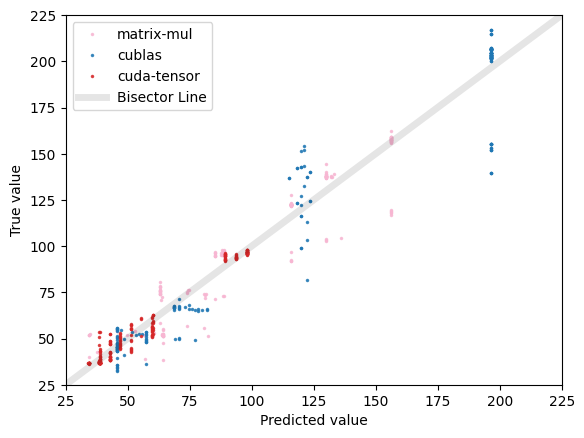

In [309]:
PlotSolution(rr3, Normalise)